In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

c:\Users\heegyukim\Desktop\project\latent-diffusion-lm


In [2]:
from src.task.optimus_v2 import OptimusTask as OptimusTaskV2
from src.task.optimus import OptimusTask as OptimusTaskV1
from coop.metric import levenshtein_batch, levenshtein
import torch
from datasets import load_dataset

In [4]:
# ckpt = "checkpoint/optimus-v2-44M/optimus-v2-tiny-vae.ckpt"
ckpt = "checkpoint/optimus-v2-44M/optimus-v2-tiny-vae.ckpt"
# ckpt = "checkpoint/optimus-v1-base-500k.ckpt"
task = OptimusTaskV2.load_from_checkpoint(ckpt)

In [5]:
task.eval()
torch.set_grad_enabled(False)

# Reconstruction Test

In [6]:
def reconstruct(text, show=True):
    latent = task.encode(text)
    rec = task.generate(latent, max_length=64, num_beams=4)[0]
    if show:
        print(rec)
    return rec

reconstruct("안녕하세요")
reconstruct("오늘도, 즐거운 하루~ ㅎㅎ")
reconstruct("살다 보면, 이런 날도 있는 것 아니겠니?")
reconstruct("그러니 가끔은 좀 편하게 쉬어도 된다.")
reconstruct("살다 보면, 이런 날도 있는 것 아니겠니? 그러니 가끔은 좀 편하게 쉬어도 된다.")
reconstruct("우리 아들, 서울대 합격했어!")
reconstruct("차 산지 1년이나 됐는데 여태 몰라서 못썼네요")
reconstruct("얼음맥주 일본이 미개했었다는 수준 잘보고갑니다.")
reconstruct("틸러슨 장관은 16일 워싱턴에서 미국외교장관과 만나 북미, 남북대화에 관해 논의할 예정이다.")
reconstruct("당초 유족들은 가족장을 추진하였으나 전직 대통령에 대한 예우와 전 국민적인 추모열기로 국민장으로 치러졌다.")
reconstruct("컴퓨터 과학을 둘러싼 논의가 활발해졌지만, 그 전체로서 컴퓨터 과학이 경영관리의 혁신에 있어서 진실로 가치 있는 과학체계임을 명백히 할 필요가 있다.")
reconstruct("이 상태에서 누굴 물어도 흡혈귀로 전염시키지는 않지만, 메모라이즈 시와 캐스팅 시 모두 일정량의 피를 소모한다.")
reconstruct("이 대화에서 김재규가 자신은 한다면 하는 사람이라고 한 것은 김계원에게 확고한 결의를 보여주고 믿음을 주기 위해 했던 말인 것으로 짐작된다.")


안녕하세요
오늘도 즐거운, 하루 ~
살다 보면, 이런 날도 있는 것 아니겠니?
그러니 가끔은 좀 편하게 쉬어도 된다.
살다 보면, 이런 거도 있겠죠. 돈은 아니니 가끔 편하게 쉬는게 좀 된다.
우리 아들, 서울대 합격했어!
차 마리오 이것이시간왔는데 여태 몰라서 못썼네요
얼음맥주 일본이 미개했었다는 수준 잘보고갑니다.
장관은 16일 평양판위원회에서 미국외교장관과 만나 북미, 남북대화에 관해 논의할 예정이다.
당초 가족들을장하였으며 전직 대통령에 대한 추진하였지만 아기와 국민의 추모기로 국민열장으로 치러졌다.
컴퓨터 과학을 이어지면서도 방대한 문제가며, 과학 전체로서 그 경영관리에 있어 혁신의 과학 가치가 있는 사이비체임을 명확히 할 수도 있다.
이 상태에서 느낀 토도혈귀를 전염시키지는 않지만, 시쉬라이즈와 스케줄 시량의 피를 모두 소모한다.
이 대화에서는 김태규를 받은 것이라고 하는 한 사람은 김계원에게 확고한 의지를 보여주고, 태어날 것을 위해 말해버린 것으로 하였다.


'이 대화에서는 김태규를 받은 것이라고 하는 한 사람은 김계원에게 확고한 의지를 보여주고, 태어날 것을 위해 말해버린 것으로 하였다.'

In [7]:
reconstruct("언제쯤 이 나라는 좀 평온해질까?")

언제 이 나라는 좀 평온해질까?


'언제 이 나라는 좀 평온해질까?'

In [8]:
def reconstruct_batch(x):
    r = task.generate(task.encode(x["sentence"]), max_length=64, early_stopping=True)
    return {
        "reconstruct": r
    }


eval_ds = load_dataset("heegyu/vae_eval", split="test", use_auth_token=True)
eval_ds = eval_ds.map(reconstruct_batch, batched=True, batch_size=64)
eval_ds[0]

Using custom data configuration heegyu--vae_eval-5adb9ae751b4aeab


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 998.64it/s]
Parameter 'function'=<function reconstruct_batch at 0x000001CFFFBF94C0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Dataset parquet downloaded and prepared to C:/Users/heegyukim/.cache/huggingface/datasets/heegyu___parquet/heegyu--vae_eval-5adb9ae751b4aeab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


 88%|████████▊ | 7/8 [05:20<00:45, 45.79s/ba]


{'sentence': "그는 ▲인적자본 개발의 기회 불평등 ▲중상류층의 불공정한 기회 가로채기 등을 청년 불평등 원인으로 꼽았다.김 기획총장은 '중상류층의 경우 노동시장에서 큰 가치로 인정되는 능력을 개발할 수 있는 기회가 많다.",
 'reconstruct': "그는 ▲자본적 수준의 소외등인력 대기업과 복잡한 사례들의 냉대기'이라는 공약과 청년 잡았다. 하지만 금융감독의 인식에서는 시장에서 생활할 수 없는 자가능한 가치의 개발률로 평가되는 등의 생활권을"}

In [9]:
levenshtein_batch(eval_ds["sentence"], eval_ds["reconstruct"])

0.3688067437110688

In [15]:
eval_ds[200]

{'sentence': '민주진보세력 대통합론과 위기.', 'reconstruct': '민주력세서리합론과 위기.'}

# Retrieval Test

In [16]:
# 유사한 문장 길이, 겹치는 단어가 많아야 하는 듯

def cosine_simm(text, targets):
    src = task.encode(text)  # (1, 512)
    tgt = task.encode(targets) # (n, 512)
    scores = torch.matmul(src, tgt.T)[0]
    print("source: ", text)
    for t, s in zip(targets, scores.tolist()):
        print(t, s)

def euclid_simm(text, targets):
    src = task.encode(text)  # (1, 512)
    tgt = task.encode(targets) # (n, 512)
    src = src.repeat((tgt.shape[0], 1))
    dist = torch.sqrt(((tgt - src) ** 2).sum(-1))

    print("source: ", text)
    for t, s in zip(targets, dist.tolist()):
        print(t, s)

text = "ㅋㅋ 오늘도 앉아서 게임밖에 안함"
targets = [
    "요즘 롤하는거 진짜 존잼임",
    "요즘 롤하는거 진짜 존잼임, 요즘은 진짜 게임밖에 안함 ㅋㅋㅋ. 하 맨날 이러고 살았으면 좋겠다 진짜",
    "엄마 오늘 저녁은 고기 먹고싶다.",
    "할 일도 없고 너무 심심한듯"
]
euclid_simm(text, targets)
cosine_simm(text, targets)

source:  ㅋㅋ 오늘도 앉아서 게임밖에 안함
요즘 롤하는거 진짜 존잼임 8.493880271911621
요즘 롤하는거 진짜 존잼임, 요즘은 진짜 게임밖에 안함 ㅋㅋㅋ. 하 맨날 이러고 살았으면 좋겠다 진짜 8.52364444732666
엄마 오늘 저녁은 고기 먹고싶다. 7.8122406005859375
할 일도 없고 너무 심심한듯 9.135533332824707
source:  ㅋㅋ 오늘도 앉아서 게임밖에 안함
요즘 롤하는거 진짜 존잼임 22.217327117919922
요즘 롤하는거 진짜 존잼임, 요즘은 진짜 게임밖에 안함 ㅋㅋㅋ. 하 맨날 이러고 살았으면 좋겠다 진짜 14.96523666381836
엄마 오늘 저녁은 고기 먹고싶다. 26.74239158630371
할 일도 없고 너무 심심한듯 17.033100128173828


# Arithmetic 연산

In [11]:
def arithmetic(src, sub, add):
    x = task.encode([src, sub, add])
    z = x[0] - x[1] + x[2]
    print(src, "-", sub, "+", add, "=", task.generate(z.unsqueeze(0))[0])

arithmetic(
    "우리 아들, 서울대 합격했어!",
    "서울대",
    "고려대"
)

arithmetic(
    "우리 아들, 서울대 합격했어!",
    "아들",
    "딸"
)

arithmetic(
    "오빠, 요즘 회사생활은 어때?",
    "회사",
    "학교"
)

arithmetic(
    "오빠, 요즘 회사생활은 어때?",
    "오빠 회사",
    "언니 학교"
)

arithmetic(
    "나 요즘 고양이 키우는데 너무 귀엽더라 ㅎㅎ",
    "고양이",
    "강아지"
)

arithmetic(
    "나 요즘 고양이 키우는데 너무 귀엽더라 ㅎㅎ",
    "귀엽다",
    "사랑스럽다"
)

d:\Anaconda3\lib\site-packages\transformers\generation_utils.py:1359: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


우리 아들, 서울대 합격했어! - 서울대 + 고려대 = 우리 아들 고려대 합격했어!
우리 아들, 서울대 합격했어! - 아들 + 딸 = 우리 딸, 서울대 합격했어!
오빠, 요즘 회사생활은 어때? - 회사 + 학교 = 오빠, 학교 요즘생활은 어때?
오빠, 요즘 회사생활은 어때? - 오빠 회사 + 언니 학교 = 언니, 요즘 학교생활은 어때?
나 요즘 고양이 키우는데 너무 귀엽더라 ㅎㅎ - 고양이 + 강아지 = 나 자전거 강아지 키우는데 너무 귀엽더라
나 요즘 고양이 키우는데 너무 귀엽더라 ㅎㅎ - 귀엽다 + 사랑스럽다 = 나 요즘 사회 키우는데 너무 사랑스럽더라


tensor(0.3130)
AxesSubplot(0.125,0.125;0.775x0.755)


d:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


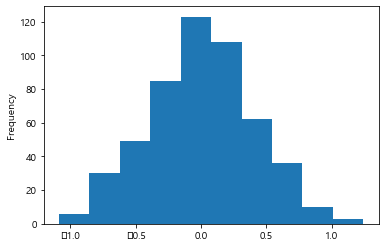

In [23]:
import pandas as pd 


def latent_diff(a, b):
    x = task.encode([a, b])
    z = x[0] - x[1]
    print(z.abs().mean())

    print(pd.Series(z.numpy()).plot.hist())

latent_diff(
    "우리 아들, 서울대 합격했어!",
    "나 요즘 고양이 키우는데 너무 귀엽더라 ㅎㅎ"
)

# Unsupervised Summarization

In [17]:

def summarize(texts):
    texts = texts.strip().split("\n")
    x = task.encode(texts).mean(0)
    print(task.generate(x.unsqueeze(0), max_length=64, num_beams=4)[0])

summarize("""
나는 오늘 친구와 만났다. 
나는 친구와 피자를 먹고 맥주를 마셨다. 
나와 친구는 밥을 먹고 보드게임 카페를 갔다. 
거기서 할리갈리를 했는데 매우 재미 있었다.
""")

summarize("""
이 겜 진짜 핵노잼인데
이럴거면 게임 왜 만듦?? ㅋㅋㅋ ㅈㄴ 노어이
노잼이네요, 회사 문 닫으셈 ㅅㄱㅋ
""")

summarize("""
잠시 마음을 놓는 순간 거세지는 게 이곳의 바람. 
마을을 떠나는 길에는 구름까지 잔뜩 몰려오더니 결국 비바람이 몰아치기 시작했다. 
하필 오늘은 펭귄 서식지에 오기로 한 날.
풀들이 다 휘어버릴 만큼 거센 바람을 보니 여기 사는 펭귄들이 걱정됐다. 
여기에서 돌아갈 수도 없다. 
이런 날씨에 펭귄이 있을까 걱정했는데 입구부터 귀여운 울음소리가 들닌다. 
손님을 처음으로 반겨준 이 녀석. 
장난감 나팔 같은 목소리가 독특하다.
얼음이 아닌 따뜻한 땅을 좋아하는 마젤란 펭귄은 이곳에 집을 짓고 매년 봄, 여름을 보낸다. 
신기하게도 같은 집에서 같은 암수가 매년 만나 이렇게 예쁜 새끼를 낳고 여름 내내 수영을 가르쳐서 가을이 되면 더 따뜻한 브라질로 떠난다고 한다. 
바람부는 허허벌판에서 5kg의 몸으로 버티는 펭귄들이 기특해 보였다. 
한 녀석은 길목에서 손님을 기다리고 있는 것 같더니 따라나서자 이렇게 줄행랑을 친다.
따라 잡을 수 없을 만큼 빨랐다. 
다가서자 신기한 듯 이리저리 고개를 돌리며 구경이다.
""")

나는 친구와 도시락을 누르고 외모다.
이 꽁이아요 그리고 소련페이지같혀 어
이렇게보 절벽에 오긴만고 그 함성로 보이는 것.


# Paraphrasing

In [10]:
texts = """
잠시 마음을 놓는 순간 거세지는 게 이곳의 바람. 
마을을 떠나는 길에는 구름까지 잔뜩 몰려오더니 결국 비바람이 몰아치기 시작했다. 
하필 오늘은 펭귄 서식지에 오기로 한 날.
풀들이 다 휘어버릴 만큼 거센 바람을 보니 여기 사는 펭귄들이 걱정됐다. 
여기에서 돌아갈 수도 없다. 
나는 오늘 친구와 만났다. 
나는 친구와 피자를 먹고 맥주를 마셨다. 
나와 친구는 밥을 먹고 보드게임 카페를 갔다. 
거기서 할리갈리를 했는데 매우 재미 있었다.
나 요즘 고양이 키우는데 너무 귀엽더라 ㅎㅎ
이 겜 진짜 핵노잼인데
이럴거면 게임 왜 만듦?? ㅋㅋㅋ ㅈㄴ 노어이
노잼이네요, 회사 문 닫으셈 ㅅㄱㅋ
""".strip().split("\n")
import numpy as np

def getRandomSamplesOnNSphere(N, R, numberOfSamples):
    # Return 'numberOfSamples' samples of vectors of dimension N 
    # with an uniform distribution on the (N-1)-Sphere surface of radius R.
    # RATIONALE: https://mathworld.wolfram.com/HyperspherePointPicking.html
    
    X = np.random.default_rng().normal(size=(numberOfSamples , N))
    return R / np.sqrt(np.sum(X**2, 1, keepdims=True)) * X

def paraphrase(text, r=5):
    x = task.encode(text)
    e = torch.tensor(getRandomSamplesOnNSphere(512, r, 1), dtype=torch.float)
    # e = torch.rand_like(x) * 0.5
    print(text, "->", task.generate(x + e, max_length=64, early_stopping=True)[0])

for text in texts:
    paraphrase(text)

잠시 마음을 놓는 순간 거세지는 게 이곳의 바람.  -> 교통비 마음을 놓는 지난 정도는 거는 삶이 소형 같아.
마을을 떠나는 길에는 구름까지 잔뜩 몰려오더니 결국 비바람이 몰아치기 시작했다.  -> 마을로 떠나서 길에는 발을 건드리지 하고 난 억패패분도 생각하고 부럽다
하필 오늘은 펭귄 서식지에 오기로 한 날. -> 하필 *은 KT에 오기로 한 날이다
풀들이 다 휘어버릴 만큼 거센 바람을 보니 여기 사는 펭귄들이 걱정됐다.  -> 풀들이랑 싸어버릴수록 빗도 부는데 사는거든...
여기에서 돌아갈 수도 없다.  -> 여기에서 올라갈 수도 없다.
나는 오늘 친구와 만났다.  -> 나는 오늘 친구와 만났다.
나는 친구와 피자를 먹고 맥주를 마셨다.  -> 나는 엄마우 디저트를 먹고 맥주 사왔다.
나와 친구는 밥을 먹고 보드게임 카페를 갔다.  -> 울 친구는 밥을 먹고 보드게임 티비장왔다.
거기서 할리갈리를 했는데 매우 재미 있었다. -> 거기서 언제갈때 사는데 잘 다를 게 없었네
나 요즘 고양이 키우는데 너무 귀엽더라 ㅎㅎ -> 나 요즘 고양이 키우는데 너무 귀엽더라
이 겜 진짜 핵노잼인데 -> 이 진짜 넘노잼인데
이럴거면 게임 왜 만듦?? ㅋㅋㅋ ㅈㄴ 노어이 -> 뭔지지 말스 왜??ㄴㄴㄴ 노김
노잼이네요, 회사 문 닫으셈 ㅅㄱㅋ -> 노잼이 높아, 전세 틀으면 굴러으러ㅎㄱ
